In [4]:
#View detected cells via brainrender

from vedo import embedWindow
embedWindow(None) 

import numpy as np
import brainrender
from brainrender import Scene
from brainrender.actors import Points
import pandas as pd


#Path to csv file containing cell locations under output\analysis\all_points.csv
cellsfile = r"...\analysis\all_points.csv"


#Modify Settings - Atlas and resolution; transparency
brainrender.settings.DEFAULT_ATLAS = "allen_mouse_10um" 
brainrender.settings.ROOT_ALPHA = 0.2  


#creates a function that reads in a csv file and 
def read_in_Cellfinder_cells(filename):
    #this function reads in specific columns of a csv file 
    cells = pd.read_csv(filename, usecols=[3,4,5], names = ['X','Y','Z'], 
                        skiprows = [0]) #skip header row
      
    #creates lists from cells table 
    X = cells['X'].tolist()
    Y = cells['Y'].tolist()
    Z = cells['Z'].tolist()
    
    #data is in voxels, so multiply by atlas resolution 
    AtlasRes = 10
    X = [element * AtlasRes for element in X]
    Y = [element * AtlasRes for element in Y]
    Z = [element * AtlasRes for element in Z]
    pts = [[x, y, z] for x, y, z in zip(X, Y, Z)]
    return np.vstack(pts)


#uses function to read in cells
coordinates1 = read_in_Cellfinder_cells(cellsfile)


#creates the scene with a title
scene = Scene(title="PV-Cre vHPC")


#add in the relevant brain regions - use acronyms, alpha sets the trancparency of the added brain regions
scene.add_brain_region("HPF", alpha=0.35)


# Add points to scene and give colour
scene.add(Points(coordinates1, name="Cells", colors="steelblue"))


# renders the scene
scene.content
scene.render()
scene.close()

╭─────────────────────────────────╮
│                                 │
│   Scene actors                  │
│   ────────────                  │
│                                 │
│   - root (type: brain region)   │
│   - title (type: title)         │
│   - HPF (type: brain region)    │
│   - Cells (type: Points)        │
│                                 │
╰─────────────────────────────────╯


Closing window. Plotter.escaped is set to True.


In [7]:
#View generated injection trajectories (forceps minor)

from vedo import embedWindow
embedWindow(None) 

from brainrender import Scene
from brainrender.actors.streamlines import make_streamlines
from brainrender.actors import ruler
import pandas as pd
import numpy as np
from scipy import interpolate

scene = Scene()

scene.root.alpha(0.1)
scene.root._needs_silhouette = False


x = [3600, 4900, 3600]
y = 3500
z = [4400, 5650, 6900]

cs = interpolate.CubicSpline(z, x)

new_z = list(range(4400, 6950, 50))
new_x = cs(new_z)
new_y = [y] * len(new_z)

new_x1 = new_x + 50
new_x2 = new_x - 50

injection1 = np.array([3650, 3500, 4400])
injection2 = np.array([3550, 3500, 6900])

stream1 = pd.DataFrame(
{
"lines":[[[{"x":x, "y":y, "z":z} for x,y,z in zip(new_x1, new_y, new_z)]]],
"injection_sites": [[{key: value for key, value in zip("xyz", injection1)}]]
})

stream2 = pd.DataFrame(
{
"lines":[[[{"x":x, "y":y, "z":z} for x,y,z in zip(new_x2, new_y, new_z)]]],
"injection_sites": [[{key: value for key, value in zip("xyz", injection2)}]]
})

cc = scene.add_brain_region("cc", alpha=0.2)

rul = ruler(injection1, injection2, unit_scale=0.001, units="mm")

scene.add(
    rul,
    *make_streamlines(stream1, color="blue", alpha=0.5, show_injection=True),
    *make_streamlines(stream2, color="red", alpha=0.5, show_injection=True)
)

scene.render()

scene.close()

In [ ]:
#Barplot cell density hemispheres

import pandas as pd
import matplotlib.pyplot as plt
#%pip install seaborn
import seaborn as sns

#creates a dictionary with brain regions and abbreviations from a csv file saved under C:\Users\User\.brainglobe\allen_mouse_10um_v1.2\structures.csv
dic = pd.read_csv(r'C:\Users\...\.brainglobe\allen_mouse_10um_v1.2\structures.csv')
dic2 = dic[['name', 'acronym']]
dictionary= dict(zip(dic2['name'], dic2['acronym']))


#reads in specified columns of the Cellfinder summary data, excludes all brain regions with no detected cells and replaces the brain regions with abbreviations 
df = pd.read_csv(r'...\analysis\summary.csv')
df = df[['structure_name', 'left_cells_per_mm3', 'right_cells_per_mm3']]
#df = df[df['right_cells_per_mm3'] > 500]
df = df[(df != 0).all(axis=1)]
df = df.replace(dictionary)


#uncomment for stacked bar plot
#df.set_index("structure_name").plot(kind="bar", stacked=True)


#as the data is in the wrong format for a barplot with two bars per brain region, the data is transformed
plot_df = pd.DataFrame()
for side in ["left", "right"]:
    col = "{}_cells_per_mm3".format(side)
    side_df = df[["structure_name", col]].rename({col: "cells_per_mm3"}, axis=1)
    side_df["side"] = side
    plot_df = pd.concat([plot_df, side_df])
    plot_df = plot_df.sort_values(by='cells_per_mm3', ascending=False)
    #plot_df = plot_df[plot_df['cells_per_mm3'] >= 300]


#creates a barplot with two bars, one for each hemisphere
fig, ax = plt.subplots()
sns.barplot(data=plot_df, x='structure_name', y='cells_per_mm3', hue="side", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 90, horizontalalignment='center')
ax.set(xlabel='Brain region', ylabel='Cell density [Cells/mm$^{3}$]')


#saves barplot to specified folder, dpi changes the resolution of the saved plot
plt.savefig(r'...\barplot-cell_density.png', bbox_inches='tight', dpi=400)
plt.show()

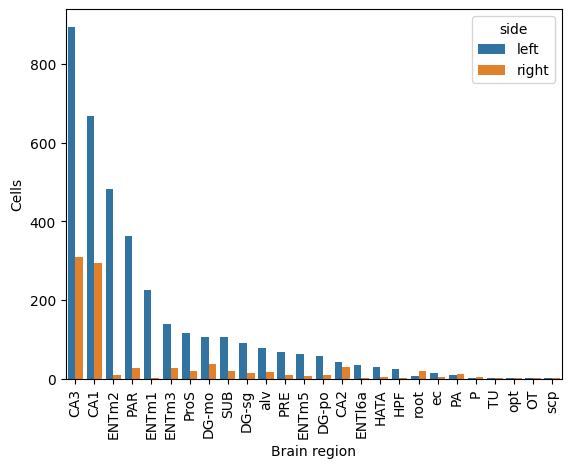

In [3]:
#Barplot cell count hemispheres

import pandas as pd
import matplotlib.pyplot as plt
#%pip install seaborn
import seaborn as sns

#creates a dictionary with brain regions and abbreviations from a csv file saved under C:\Users\User\.brainglobe\allen_mouse_10um_v1.2\structures.csv
dic = pd.read_csv(r'C:\Users\...\.brainglobe\allen_mouse_10um_v1.2\structures.csv')
dic2 = dic[['name', 'acronym']]
dictionary= dict(zip(dic2['name'], dic2['acronym']))


#reads in specified columns of the Cellfinder summary data, excludes all brain regions with no detected cells and replaces the brain regions with abbreviations 
df = pd.read_csv(r'...\analysis\summary.csv')
df = df[['structure_name', 'left_cell_count', 'right_cell_count']]
#df = df[df['right_cell_count'] > 100]
df = df[(df != 0).all(axis=1)]
df = df.replace(dictionary)


#uncomment for stacked bar plot
#df.set_index("structure_name").plot(kind="bar", stacked=True)


#as the data is in the wrong format for a barplot with two bars per brain region, the data is transformed
plot_df = pd.DataFrame()
for side in ["left", "right"]:
    col = "{}_cell_count".format(side)
    side_df = df[["structure_name", col]].rename({col: "cell_count"}, axis=1)
    side_df["side"] = side
    plot_df = pd.concat([plot_df, side_df])
    plot_df = plot_df.sort_values(by='cell_count', ascending=False)
    #plot_df = plot_df[plot_df['cells_per_mm3'] >= 300]


#creates a barplot with two bars, one for each hemisphere
fig, ax = plt.subplots()
sns.barplot(data=plot_df, x='structure_name', y='cell_count', hue="side", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 90, horizontalalignment='center')
ax.set(xlabel='Brain region', ylabel='Cells')


#saves barplot to specified folder, dpi changes the resolution of the saved plot
plt.savefig(r'...\barplot-cell_count.png', bbox_inches='tight', dpi=400)
plt.show()

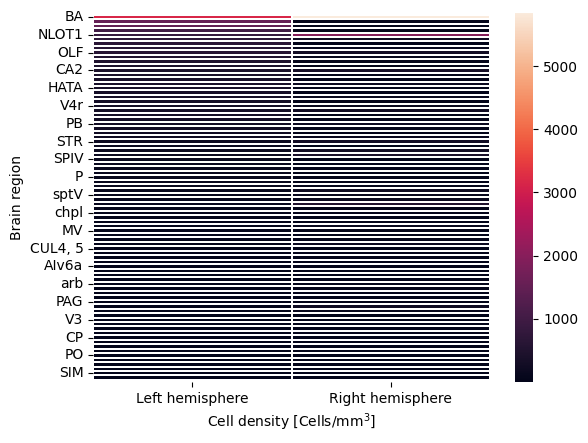

In [14]:
#Heatmap

import pandas as pd
import matplotlib.pyplot as plt
#%pip install seaborn
import seaborn as sns


#creates a dictionary with brain regions and abbreviations from a csv file saved under C:\Users\User\.brainglobe\allen_mouse_10um_v1.2\structures.csv
df = pd.read_csv(r'C:\Users\...\.brainglobe\allen_mouse_10um_v1.2\structures.csv')
df2 = df[['name', 'acronym']]
dictionary= dict(zip(df2['name'], df2['acronym']))


#reads in specified columns of the Cellfinder summary data, excludes all brain regions with no detected cells and replaces the brain regions with abbreviations
data = pd.read_csv(r'...\analysis\summary.csv')
data1 = data[['structure_name', 'left_cells_per_mm3', 'right_cells_per_mm3']]
data2 = data1[(data1 != 0).all(1)].set_index('structure_name').sort_values(by='left_cells_per_mm3', ascending=False)
data3=data2.rename(dictionary)


#creates a heatmap
sns.heatmap(data=data3, xticklabels=['Left hemisphere', 'Right hemisphere'], linewidth=0.005)
plt.xlabel("Cell density [Cells/mm$^{3}$]")
plt.ylabel("Brain region")
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)


#saves barplot to specified folder, dpi changes the resolution of the saved plot
plt.savefig(r'...\heatmap.png', bbox_inches='tight', dpi=400)
plt.show()

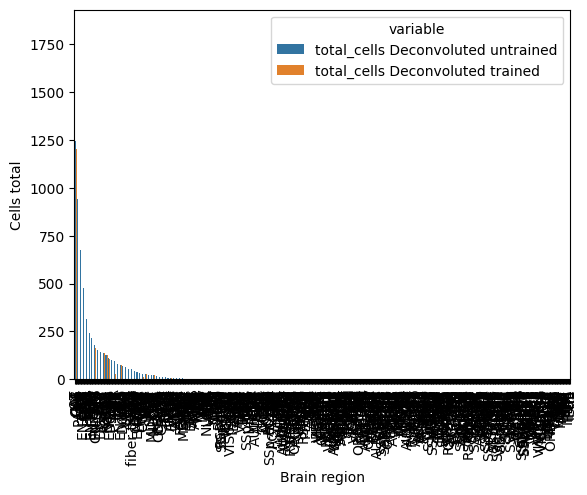

In [68]:
#Compare two dataframes 

import pandas as pd
import matplotlib.pyplot as plt
#%pip install seaborn
import seaborn as sns


#creates a dictionary with brain regions and abbreviations from a csv file saved under C:\Users\User\.brainglobe\allen_mouse_10um_v1.2\structures.csv
dic = pd.read_csv(r'C:\Users\muelle11\.brainglobe\allen_mouse_10um_v1.2\structures.csv')
dic2 = dic[['name', 'acronym']]
dictionary= dict(zip(dic2['name'], dic2['acronym']))



df = pd.read_csv(r'D:\develop\Cellfinder_Test\Allen-10um\Cropped\Deconvolution\output_cellfinder_untrained\analysis\summary.csv')
df = df[['structure_name', 'total_cells']]
df = df.set_index('structure_name')
df = df.rename(dictionary)

df1 = pd.read_csv(r'D:\develop\Cellfinder_Test\Allen-10um\Cropped\Deconvolution\output_cellfinder_trained\analysis\summary.csv')
df1 = df1[['structure_name', 'total_cells']]
df1 = df1.set_index('structure_name')
df1 = df1.rename(dictionary)

joined_df = df.join(df1, lsuffix=" Deconvoluted untrained", rsuffix=" Deconvoluted trained").fillna(0).astype(int).melt(ignore_index=False)


fig, ax = plt.subplots()
sns.barplot(data=joined_df, x=joined_df.index, y='value', hue="variable")
ax.set_xticklabels(ax.get_xticklabels(), rotation= 90, horizontalalignment='center')
ax.set(xlabel='Brain region', ylabel='Cells total')




#saves barplot to specified folder, dpi changes the resolution of the saved plot
plt.show()

In [17]:
#Plot neural network training

import pandas as pd
#%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r'D:\develop\Cellfinder_Test\Allen 10um\Cropped\Training data\Trained\training.csv')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(data=df, x='epoch', y='accuracy', color='green', ax=ax1)
sns.lineplot(data=df, x='epoch', y='val_accuracy', color='green', ax=ax1, style=True, dashes=[(2,2)])
ax1.legend(labels=['Accuracy','Validation Accuracy'], loc='center left')
ax1.set_ylim(0.95,1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(0,50)

sns.lineplot(data=df, x='epoch', y='loss', color='blue', ax=ax2)
sns.lineplot(data=df, x='epoch', y='val_loss', color='blue', ax=ax2, style=True, dashes=[(2,2)])
ax2.legend(labels=['Loss','Validation Loss'], loc='center right')
ax2.set_ylim(0,0.2)
ax2.set_ylabel('Loss')

#plt.axvline(x=21, linestyle='--', color='red')
#plt.text(21.2, 0.05, 'Epoch 21', color='red')

plt.savefig(r'D:\develop\Cellfinder_Test\Allen 10um\Cropped\Training data\Trained\compare.png', bbox_inches='tight', dpi=400)
plt.show()

Note: you may need to restart the kernel to use updated packages.


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\develop\\Cellfinder_Test\\Allen 10um\\Cropped\\Training data\\Trained\\training.csv'